In [1]:
%%capture
%pip install -U 'rockfish[labs]' -f 'https://packages.rockfish.ai'

In [2]:
import rockfish as rf
import rockfish.actions as ra
import rockfish.labs as rl

Please replace `YOUR_API_KEY` with the assigned API key string. Note that it should be without quotes.

For example, if the assigned API Key is `abcd1234`, you can do the following

```python
%env ROCKFISH_API_KEY=abcd1234
conn = rf.Connection.from_env()
```

If you do not have API Key, please reach out to support@rockfish.ai.


In [3]:
# %env ROCKFISH_API_KEY=YOUR_API_KEY
# conn = rf.Connection.from_env()
conn = rf.Connection.from_config("staging")

In [4]:
# download our example of timeseries data: finance.csv
!wget --no-clobber https://docs.rockfish.ai/tutorials/finance.csv

File ‘finance.csv’ already there; not retrieving.



I0000 00:00:1738883124.690493 19660559 fork_posix.cc:77] Other threads are currently calling into gRPC, skipping fork() handlers


In [4]:
dataset = rf.Dataset.from_csv("finance", "finance.csv")
dataset.to_pandas()

,customer,age,gender,merchant,category,amount,fraud,timestamp
0,C1093826151,4,M,M348934600,transportation,4.55,0,2023-01-01
1,C575345520,2,F,M348934600,transportation,76.67,0,2023-01-01
2,C1787537369,2,M,M1823072687,transportation,48.02,0,2023-01-01
3,C1732307957,5,F,M348934600,transportation,55.06,0,2023-01-01
4,C842799656,1,F,M348934600,transportation,25.62,0,2023-01-01
...,...,...,...,...,...,...,...,...
49995,C1971105040,3,M,M348934600,transportation,67.91,0,2023-01-20
49996,C51444479,3,M,M348934600,transportation,32.27,0,2023-01-20
49997,C1096642744,5,M,M1535107174,wellnessandbeauty,149.70,0,2023-01-20
49998,C1166683343,2,F,M1823072687,transportation,24.78,0,2023-01-20


In [ ]:
config = ra.TrainTimeGAN.Config(
    encoder=ra.TrainTimeGAN.DatasetConfig(
        timestamp=ra.TrainTimeGAN.TimestampConfig(field="timestamp"),
        metadata=[
            ra.TrainTimeGAN.FieldConfig(field="customer", type="session"),
            ra.TrainTimeGAN.FieldConfig(field="age", type="categorical"),
            ra.TrainTimeGAN.FieldConfig(field="gender", type="categorical"),
        ],
        measurements=[
            ra.TrainTimeGAN.FieldConfig(field="merchant", type="categorical"),
            ra.TrainTimeGAN.FieldConfig(field="category", type="categorical"),
            ra.TrainTimeGAN.FieldConfig(field="amount"),
            ra.TrainTimeGAN.FieldConfig(field="fraud", type="categorical"),
        ],
    ),
    doppelganger=ra.TrainTimeGAN.DGConfig(
        sample_len=19, epoch=10, epoch_checkpoint_freq=10, batch_size=64
    ),
)

# create train action
train = ra.TrainTimeGAN(config)

In [6]:
builder = rf.WorkflowBuilder()
builder.add_dataset(dataset)
builder.add_action(train, parents=[dataset])
workflow = await builder.start(conn)
print(f"Workflow: {workflow.id()}")

Workflow: 4s5TDxonebrW8LftxK6Sje


In [7]:
async for log in workflow.logs():
    print(log)

2025-02-06T23:06:41Z dataset-load: INFO Downloading dataset '6f6n9d6uCZK3HPFJBnG49r'
2025-02-06T23:06:41Z dataset-load: INFO Downloaded dataset '6f6n9d6uCZK3HPFJBnG49r' with 50000 rows
2025-02-06T23:06:48Z train-time-gan: INFO Starting DG training job
2025-02-06T23:07:05Z train-time-gan: INFO Epoch 1 completed.
2025-02-06T23:07:17Z train-time-gan: INFO Epoch 2 completed.
2025-02-06T23:07:30Z train-time-gan: INFO Epoch 3 completed.
2025-02-06T23:07:43Z train-time-gan: INFO Epoch 4 completed.
2025-02-06T23:07:56Z train-time-gan: INFO Epoch 5 completed.
2025-02-06T23:08:08Z train-time-gan: INFO Epoch 6 completed.
2025-02-06T23:08:21Z train-time-gan: INFO Epoch 7 completed.
2025-02-06T23:08:33Z train-time-gan: INFO Epoch 8 completed.
2025-02-06T23:08:45Z train-time-gan: INFO Epoch 9 completed.
2025-02-06T23:08:56Z train-time-gan: INFO Epoch 10 completed.
2025-02-06T23:08:59Z train-time-gan: INFO Training completed. Uploaded model 5885c6f3-e4df-11ef-a0ee-0e92d88750cd


In [9]:
model = await workflow.models().last()
model

Model(id='5885c6f3-e4df-11ef-a0ee-0e92d88750cd', labels={'workflow_id': '4s5TDxonebrW8LftxK6Sje'}, create_time=datetime.datetime(2025, 2, 6, 23, 8, 58, tzinfo=datetime.timezone.utc), size_bytes=19993600)

In [10]:
generate = ra.GenerateTimeGAN()
save = ra.DatasetSave(name="synthetic")
target = (
    ra.SessionTarget()
)  # users can assign a value to `target` parameter. Otherwise, it will generate the same number of sessions as the training dataset.
builder = rf.WorkflowBuilder()
builder.add_model(model)
builder.add_action(generate, parents=[model, target])
builder.add_action(target, parents=[generate])
builder.add_action(save, parents=[generate])
workflow = await builder.start(conn)

In [20]:
async for log in workflow.logs():
    print(log)

2025-02-06T23:09:25Z session-target: INFO Grouping on: ['session_key']
2025-02-06T23:09:25Z session-target: INFO new=1000 total=1000 needs=2765
2025-02-06T23:09:22Z generate-time-gan: INFO Downloading model with model_id='5885c6f3-e4df-11ef-a0ee-0e92d88750cd'...
2025-02-06T23:09:26Z session-target: INFO Grouping on: ['session_key']
2025-02-06T23:09:26Z session-target: INFO new=1000 total=2000 needs=1765
2025-02-06T23:09:23Z generate-time-gan: INFO Generating 1000 sessions...
2025-02-06T23:09:25Z dataset-save: INFO using field 'session_key' to concatenate tables
2025-02-06T23:09:27Z session-target: INFO Grouping on: ['session_key']
2025-02-06T23:09:27Z session-target: INFO new=1000 total=3000 needs=765
2025-02-06T23:09:28Z session-target: INFO Grouping on: ['session_key']
2025-02-06T23:09:28Z session-target: INFO new=1000 total=4000 needs=-235
2025-02-06T23:09:25Z dataset-save: INFO Saved dataset '4dONPQ3jQSRwWQB1t7ucwq' with 14295 rows
2025-02-06T23:09:26Z dataset-save: INFO using fiel

In [21]:
syn = await workflow.datasets().concat(conn)
syn.to_pandas()

,timestamp,amount,age,gender,merchant,category,fraud,session_key
0,2023-01-01 11:46:50.502,110.094640,3,M,M45060432,wellnessandbeauty,0,1000.0
1,2023-01-02 00:29:53.177,98.076531,3,M,M855959430,sportsandtoys,0,1000.0
2,2023-01-02 10:01:10.045,84.030466,3,M,M480139044,wellnessandbeauty,0,1000.0
3,2023-01-02 18:48:58.206,91.239705,3,M,M1823072687,health,0,1000.0
4,2023-01-01 10:09:05.725,86.501335,2,F,M348934600,transportation,0,1001.0
...,...,...,...,...,...,...,...,...
53543,2023-01-10 22:30:53.578,180.569417,1,M,M348934600,transportation,0,999.0
53544,2023-01-11 17:30:39.964,171.099586,1,M,M348934600,transportation,0,999.0
53545,2023-01-12 16:37:31.441,192.420940,1,M,M348934600,transportation,0,999.0
53546,2023-01-13 12:45:50.061,158.300464,1,M,M348934600,transportation,0,999.0


### Evaluation


In [39]:
# assign metadata fields or session_key to both datasets in order to compute
# session related metrics
dataset = dataset.with_table_metadata(
    rf.TableMetadata(metadata=["customer", "age", "gender"])
)
syn = syn.with_table_metadata(rf.TableMetadata(metadata=["session_key"]))

**1. session length**


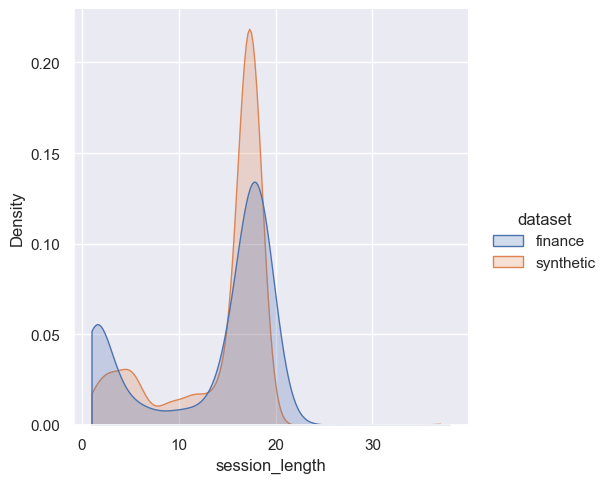

In [41]:
source_sess = rf.metrics.session_length(dataset)
syn_sess = rf.metrics.session_length(syn)
rf.labs.vis.plot_kde([source_sess, syn_sess], "session_length")

**2. interarrival time**

Here the unit for duration is in seconds


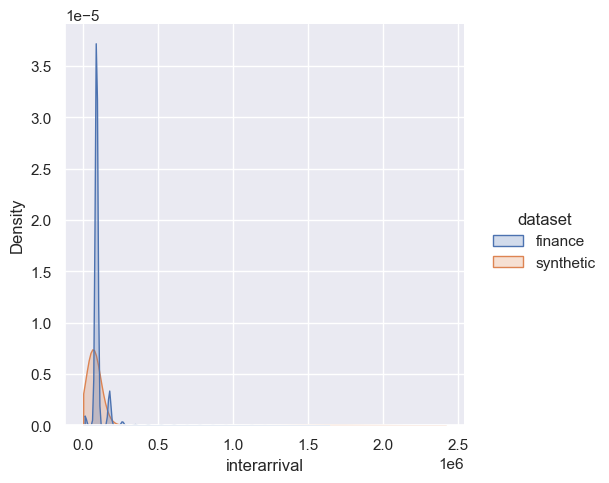

In [42]:
timestamp = "timestamp"
source_interarrival = rf.metrics.interarrivals(dataset, timestamp)
syn_interarrival = rf.metrics.interarrivals(syn, timestamp)
rf.labs.vis.plot_kde(
    [source_interarrival, syn_interarrival], "interarrival", duration_unit="s"
)

**3. numerical columns**


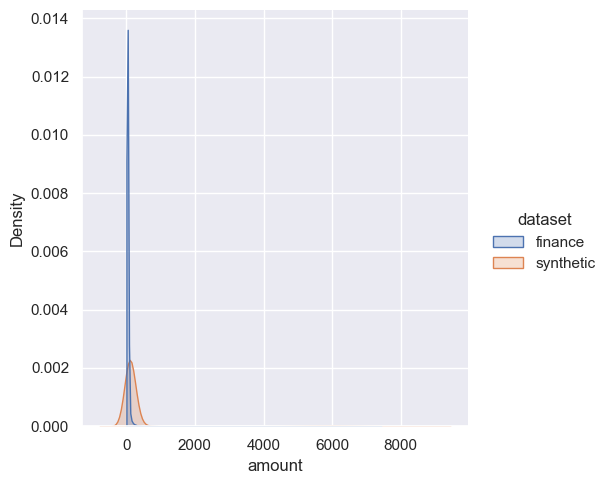

In [ ]:
rf.labs.vis.plot_kde([dataset, syn], "amount")

**4. categorical columns**

If there is a large categorical column containing over 10 categories, we plot the Top10 bars for users to compare.

NB. If you want to show more than Top10, update the number of `nlargest`


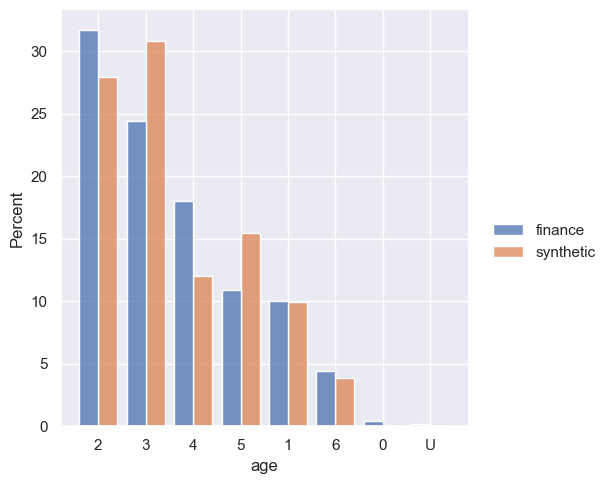

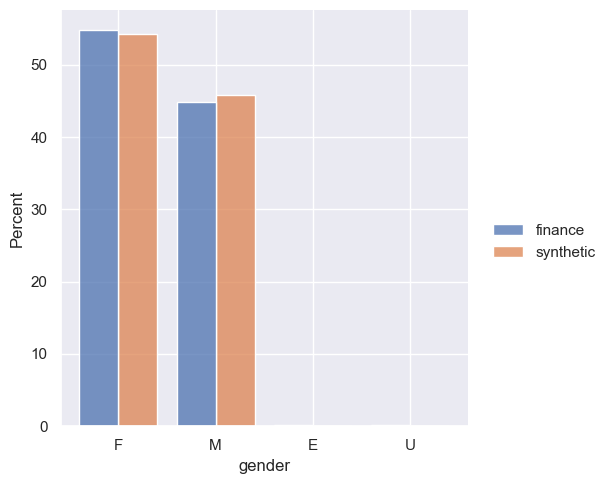

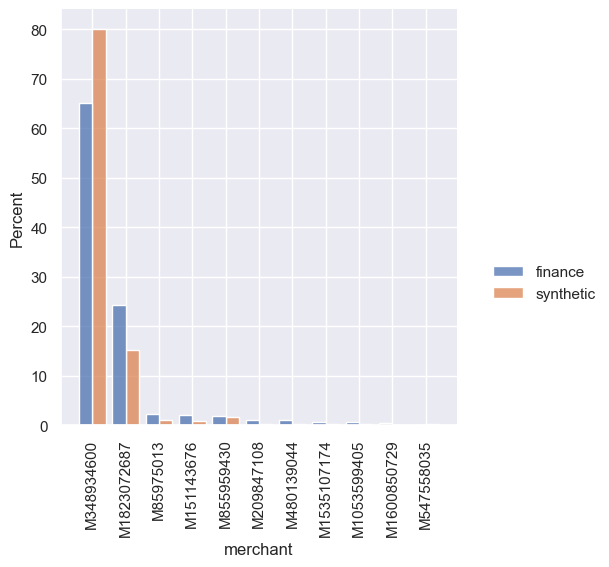

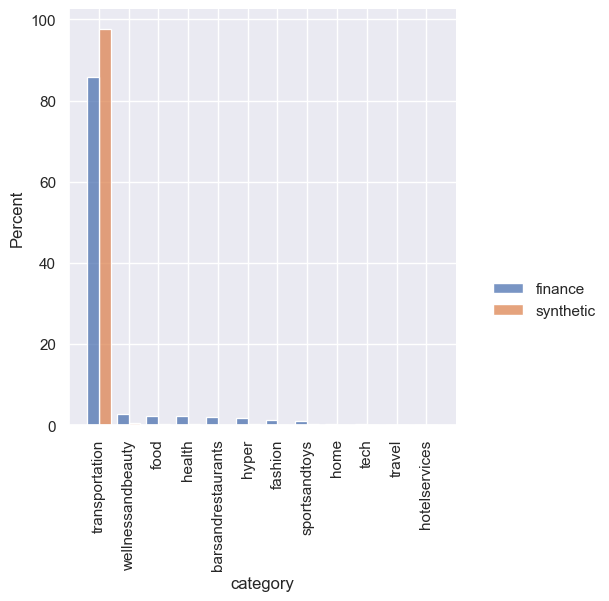

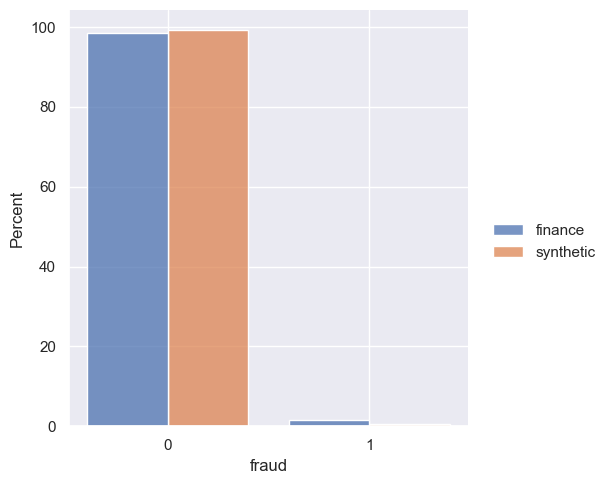

In [45]:
for col in ["age", "gender", "merchant", "category", "fraud"]:
    source_agg = rf.metrics.count_all(dataset, col, nlargest=10)
    syn_agg = rf.metrics.count_all(syn, col, nlargest=10)
    rf.labs.vis.plot_bar([source_agg, syn_agg], col, f"{col}_count")